# Imagenet Greyscale Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `imagenet_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance

* Dataset size: `146.899991342 GB` (`imagenet/ILSVRC/Data/CLS-LOC/train> du -hb .` / 1000 / 1000)
* Amount of `.JPEG` files: `1281167` (`imagenet/ILSVRC/Data/CLS-LOC/train> find . -name "*.JPEG" | wc -l`)
* Avg. filesize: `0.11466107957978935 MB`
* Avg. resolution (Imagenet paper): `400x350`
* Sample sizes (rounded to second decimal):
    * `   0500:        57.33 MB` 
    * `   1000:       114.66 MB`
    * `   2000:       229.32 MB`
    * `   4000:       458.64 MB`
    * `   8000:       917.29 MB`
    * `1281167: 146899.99 MB` 

In [1]:
full_dataset_samplecount = 1281167
running_sample_count = 500 #full_dataset_samplecount

In [3]:
%load_ext autoreload
%autoreload 2
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

local_fig_dir = "imagenet-pipeline"
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

## 1. Read logs for both experiments

In [4]:
log_path = "/logs/before-centering"
path_to_cum_df = f"{log_path}/full-log_cum-df.csv"
path_to_cum_dstat_df = f"{log_path}/full-log_cum-dstat-df.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                 , path_to_cum_df = path_to_cum_df)
gs_after_cum_dstat_df = analysis.to_cum_dstat_df()
gs_after_cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
gs_after_cum_df = gs_after_cum_df.sort_values(by='split_name')
# add a column that allows to distinguish between the runs
gs_after_cum_df["exp_type"] = "gs_after_resize"
strategies   = list(gs_after_cum_df.split_name.unique())
renamed_strategies_gs_after = ["unprocessed", "concatenated", "decoded", "resized", "applied-\ngreyscale", "pixel-\ncentered"]

log_path = "/logs/after-centering"
path_to_cum_df = f"{log_path}/full-log_cum-df.csv"
path_to_cum_dstat_df = f"{log_path}/full-log_cum-dstat-df.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
gs_after_pc_cum_dstat_df = analysis.to_cum_dstat_df()
gs_after_pc_cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
gs_after_pc_cum_df = gs_after_pc_cum_df.sort_values(by='split_name')
# add a column that allows to distinguish between the runs
gs_after_pc_cum_df["exp_type"] = "gs_after_pc"
strategies   = list(gs_after_cum_df.split_name.unique())
renamed_strategies_gs_after_pc = ["unprocessed", "concatenated", "decoded", "resized", "pixel-\ncentered", "applied-\ngreyscale"]

cum_df = pd.concat([gs_after_cum_df, gs_after_pc_cum_df])
#cum_dstat_df = pd.concat([gs_before_cum_df, gs_after_cum_df])

-- Greyscale before Resize Strategies -- 
['0-fully-online', '2-read-image', '3-decode-image', '4-apply-greyscale', '5-resize-image', '6-center-pixel-values']
['unprocessed', 'concatenated', 'decoded', 'applied-\ngreyscale', 'resized', 'pixel-\ncentered']
-- Greyscale after Resize Strategies -- 
['0-fully-online', '2-read-image', '3-decode-image', '4-resize-image', '5-apply-greyscale', '6-center-pixel-values']
['unprocessed', 'concatenated', 'decoded', 'resized', 'applied-\ngreyscale', 'pixel-\ncentered']
-- Greyscale after Pixel Center Strategies -- 
['0-fully-online', '2-read-image', '3-decode-image', '4-resize-image', '5-apply-greyscale', '6-center-pixel-values']
['unprocessed', 'concatenated', 'decoded', 'resized', 'pixel-\ncentered', 'applied-\ngreyscale']


# Greyscale Before Pixel-Centering

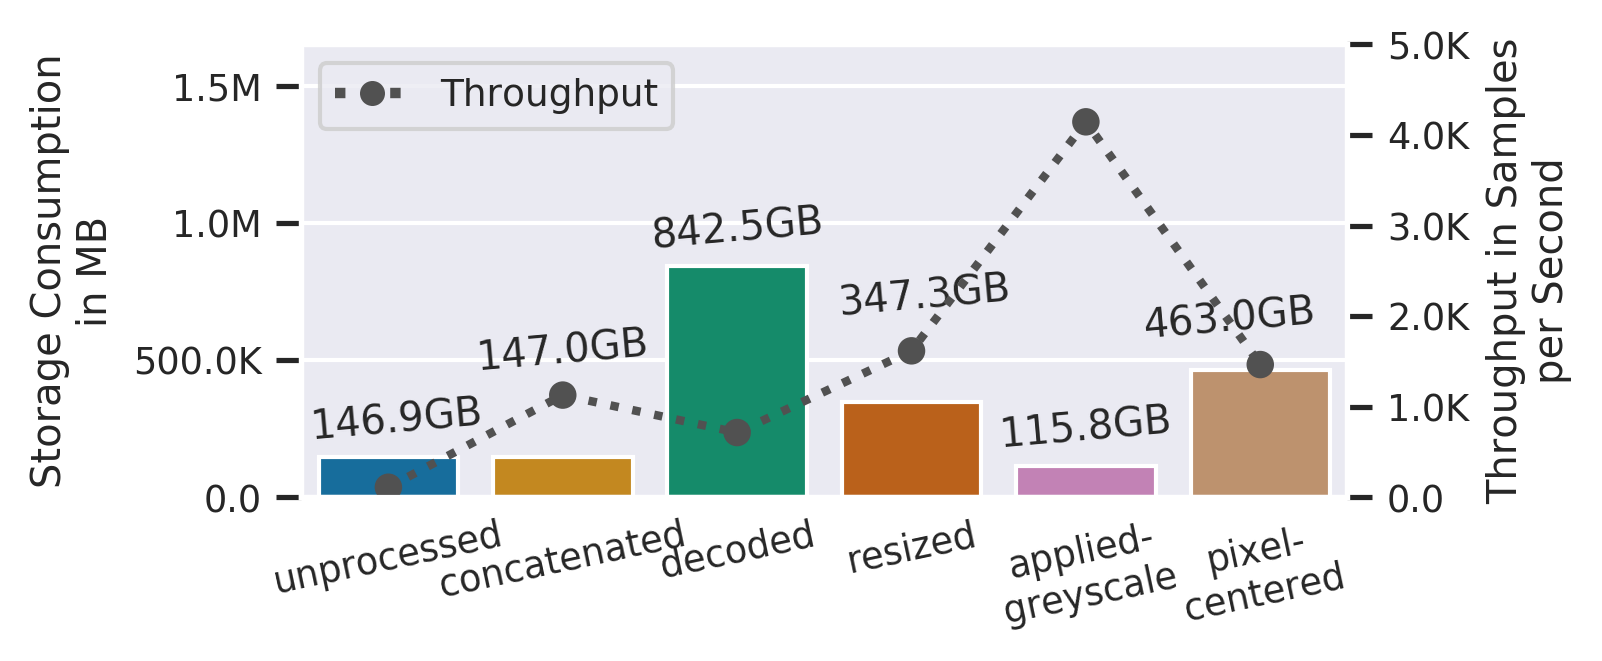

In [8]:
cum_df_temp = gs_after_cum_df.query(f"sample_count=={running_sample_count} \
                         and thread_count==8 \
                         and runs_count==0")

sample_size_mb_dict = {
    "100": 58.42 / 5.0
  , "500": 58.42
  , "1000": 116.84
  , "2000": 233.68
  , "4000": 467.35
  , "8000": 934.71
  , f"{full_dataset_samplecount}": 146899.991342
}

storage_consumption_comparison = {
    "storage_consumption_mb": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption_mb"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df_temp.sample_count.unique():
    for i, strategy in enumerate(cum_df_temp.split_name.unique()):
        shard_sizes_mb = cum_df_temp.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

sns.set(palette=default_palette, font_scale=0.8)
throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()
#sns.set(font_scale=1.4)

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps", data=cum_df_temp,
                      ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples\nper Second")
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=5, color=throughput_color, lw=2.5, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 5000))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption_mb",
        data=storage_df.query(f"sample_count=={running_sample_count}"),
        ax=ax1
    )
plot.set_xticklabels(
    renamed_strategies_gs_after
  , rotation=12
)
plot.tick_params(axis='x', which='major', pad=-1.5)
show_values_on_bars(plot, h_v="v", space=120000, rotation=5, additional_x_space=[0.05,0,0,0.08,0,-0.18]
                                                            , additional_space=[0,250000,0,250000,0,50000], storage_formatting=True)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.set(ylim=(0, 1650000))

plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("storage-vs-throughput-gs-after-resize")

# Greyscale After Pixel-Centering

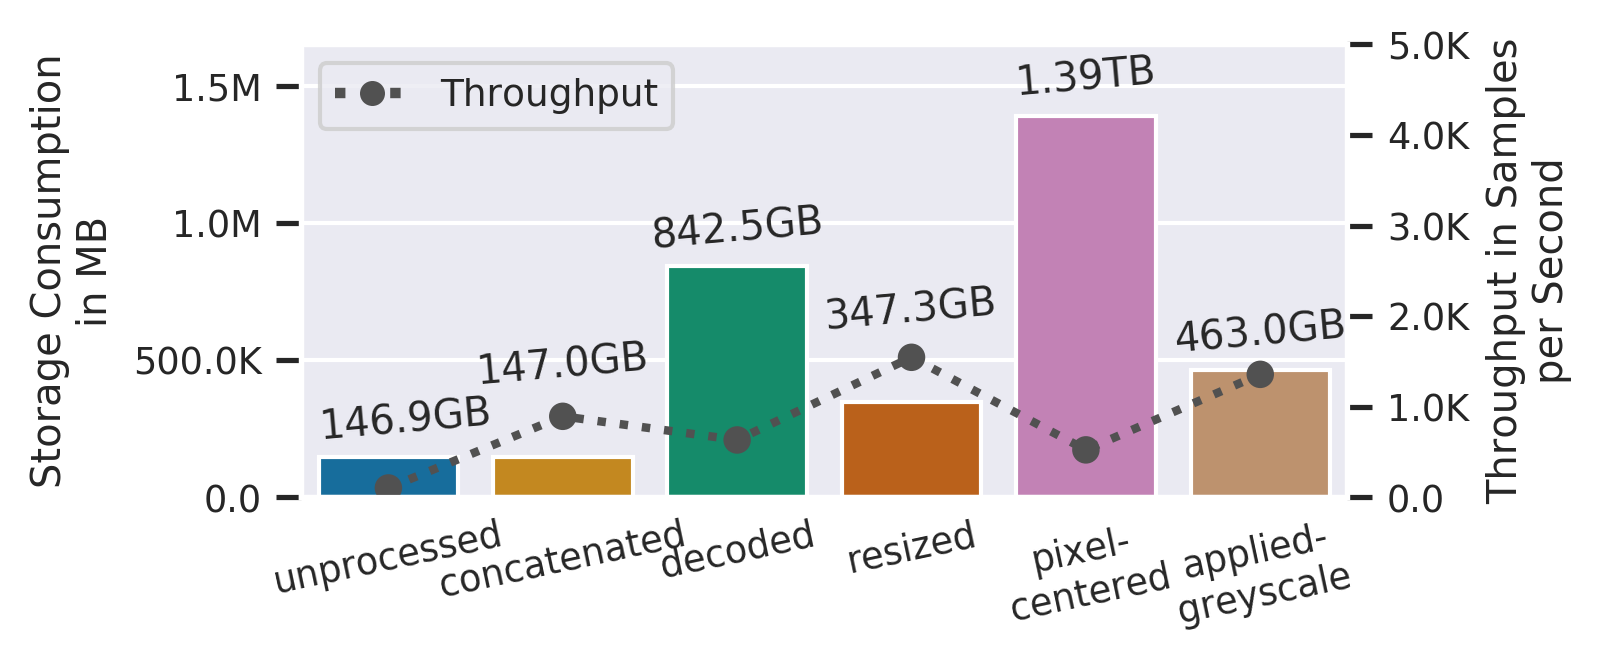

In [9]:
cum_df_temp = gs_after_pc_cum_df.query(f"sample_count=={running_sample_count} \
                         and thread_count==8 \
                         and runs_count==0")

sample_size_mb_dict = {
    "100": 58.42 / 5.0
  , "500": 58.42
  , "1000": 116.84
  , "2000": 233.68
  , "4000": 467.35
  , "8000": 934.71
  , f"{full_dataset_samplecount}": 146899.991342
}

storage_consumption_comparison = {
    "storage_consumption_mb": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption_mb"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df_temp.sample_count.unique():
    for i, strategy in enumerate(cum_df_temp.split_name.unique()):
        shard_sizes_mb = cum_df_temp.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

sns.set(palette=default_palette, font_scale=0.8)
throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()
#sns.set(font_scale=1.4)

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps", data=cum_df_temp,
                      ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples\nper Second")
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=5, color=throughput_color, lw=2.5, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 5000))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption_mb",
        data=storage_df.query(f"sample_count=={running_sample_count}"),
        ax=ax1
    )
plot.set_xticklabels(
    renamed_strategies_gs_after_pc
  , rotation=12
)
plot.tick_params(axis='x', which='major', pad=-1.5)
show_values_on_bars(plot, h_v="v", space=120000, rotation=5, additional_x_space=[0.1,0,0,0,0,0]
                                                           , additional_space=[0,200000,0,200000,0,0], storage_formatting=True)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.set(ylim=(0, 1650000))

plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("storage-vs-throughput-gs-after-pc")